# SETUP

In [1]:
import sys
sys.path.insert(0,'..')
from IPython.display import display, HTML
if not sys.warnoptions:
    import warnings
# import imblearn
from collections import Counter
from sklearn.preprocessing import LabelEncoder
# from imblearn.over_sampling import SMOTE
from matplotlib.ticker import PercentFormatter
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.constants as const
from astropy.cosmology import WMAP9 as cosmo
from datetime import datetime
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from matplotlib.cm import register_cmap
# from matplotlib_venn import venn3

from numpy.lib.stride_tricks import as_strided
import pickle
from scipy import stats
from datetime import datetime
# from spectral_cube import SpectralCube
# from imblearn.under_sampling import RandomUnderSampler

Format frequencies for mapping

In [2]:
freq_dict = {"mask_1245mosB.fits": [1401252439.970,1425092772.001],
"mask_1245mosC.fits": [1381037599.970,1404877932.001],
"mask_1245mosD.fits": [1360822751.970,1384663084.001],
"mask_1245mosE.fits": [1340607911.970,1364448244.001],
"mask_1245mosF.fits": [1320393067.970,1344233400.001],
"mask_1245mosG.fits": [1300178221.970,1324018554.001],
"mask_1245mosH.fits": [1279963378.910,1303803710.941],
"mask_1353mosB.fits": [1401179199.970,1425019532.001],
"mask_1353mosC.fits": [1380964351.970,1404804684.001],
"mask_1353mosD.fits": [1360749511.970,1384589844.001],

"mask_1353mosE.fits": [1340534667.970,1364375000.001],
"mask_1353mosF.fits": [1320319823.970,1344160156.001],
"mask_1353mosG.fits": [1300104979.970,1323945312.001],
"mask_1353mosH.fits": [1279890136.720,1303730468.751]}
freq_df = pd.DataFrame(freq_dict.values(), columns=["freq_1", "freq_2"])
freq_df["file_names"] = freq_dict.keys()
freq_df["freq_1_round"] = np.round(freq_df['freq_1']*1e-6).astype(int).astype(str)
freq_df["freq_2_round"] = np.round(freq_df['freq_2']*1e-6).astype(int).astype(str)
freq_df['freq_labels'] = freq_df[['freq_1_round', 'freq_2_round']].agg('-'.join, axis=1)
freq_df.columns = freq_df.columns.map(''.join)
freq_df['mos_name'] = freq_df.file_names.str.replace("mask_", "").str.replace(".fits", "")

## Plot Combined Scores

TODO: check v-net times

In [41]:
with open("../results/performance/mto_performance_InputBoth.txt", "rb") as fp:
    mto_time = pickle.load(fp)
mto_time_df = pd.DataFrame([(freq_dict[i.split("/")[-1].replace("loud", "mask")][0], m) for i,m in mto_time.items()], columns=['freq_1', 'time_taken'])
with open("../results/performance/vnet_performance_saved_models_28052021_101114_loud_14.txt", "rb") as fp:
    vnet_time = pickle.load(fp)
vnet_time_df = pd.DataFrame([(freq_dict[i.split("/")[-1].replace("loud", "mask")][0], m) for i,m in vnet_time.items()], columns=['freq_1', 'time_taken'])
with open("../results/performance/sofia_performance_InputBoth.txt", "rb") as fp:
    sofia_time = pickle.load(fp)
sofia_time_df = pd.DataFrame([(freq_dict[i.split("/")[-1].replace("loud", "mask")][0], m) for i,m in sofia_time.items()], columns=['freq_1', 'time_taken'])

time_df = pd.DataFrame([sofia_time_df.time_taken.mean()/60, mto_time_df.time_taken.mean()/60, vnet_time_df.time_taken.mean()/60], columns=["Elapsed Time (minutes)"])
time_df.index = ["SoFiA", "MTO", "V-NET"]
time_df

,Elapsed Time (minutes)
SoFiA,4.627141
MTO,23.003221
V-NET,394.080049


## Create catalog of sources and their attributes

Combine mask galaxies

In [505]:
real_cat_df = pd.DataFrame()
for file in listdir("../results/catalogs/ground_truth"):
    if "properties"in file:
        temp_df = pd.read_csv(f"../results/catalogs/ground_truth/{file}", index_col=0)
        temp_df["mos_name"] = file.split("_")[0]
        temp_df = temp_df.reset_index()
        real_cat_df = real_cat_df.append(temp_df)
real_cat_df = real_cat_df.reset_index(drop=True)

In [506]:
real_cat_df["z_pos"] = ((real_cat_df["bbox-3"]+ real_cat_df["bbox-0"])/2).astype(int)
real_cat_df["x_pos"] = ((real_cat_df["bbox-4"]+ real_cat_df["bbox-1"])/2).astype(int)
real_cat_df["y_pos"] = ((real_cat_df["bbox-5"]+ real_cat_df["bbox-2"])/2).astype(int)
real_cat_df[real_cat_df.type == "real"].to_csv("../results/catalogs/REAL_catalog.txt")

In [495]:
mos_names = [i.split("_")[0] for i in listdir("../results/catalogs/ground_truth") if "inserted" in i]
mock_galaxy_gt_df = pd.DataFrame()
k = 0
for mos_name in mos_names:
    temp_df1 = pd.read_csv(f"../results/catalogs/ground_truth/{mos_name}_properties.csv")
    temp_df2 = pd.read_csv(f"../results/catalogs/ground_truth/{mos_name}_inserted.csv")
    temp_df1["z_pos"] = ((temp_df1["bbox-3"]+ temp_df1["bbox-0"])/2).astype(int)
    temp_df1["x_pos"] = ((temp_df1["bbox-4"]+ temp_df1["bbox-1"])/2).astype(int)
    temp_df1["y_pos"] = ((temp_df1["bbox-5"]+ temp_df1["bbox-2"])/2).astype(int)
    overlap_df = pd.merge(temp_df1[temp_df1.type=='mock'], temp_df2, on=["z_pos", "x_pos", "y_pos"], how='outer', indicator=True)
    left_only = overlap_df[overlap_df._merge == 'left_only']
    right_only = overlap_df[overlap_df._merge == 'right_only']
    both = overlap_df[overlap_df._merge == 'both'][overlap_df.columns[:-1]]
    nearest_overlap_df = pd.DataFrame()
    for i, row in right_only.iterrows():
        distances = np.sqrt((left_only.z_pos-row.z_pos)**2 + (left_only.x_pos-row.x_pos)**2 + (left_only.y_pos-row.y_pos)**2)
        mapped_row = left_only[distances == distances.min()][right_only.columns[:-8]]
        joined_df = mapped_row.reset_index(drop=True).join(pd.DataFrame([row]).reset_index(drop=True)[["z_pos", "x_pos", "y_pos", "gal_file", "orig_mass", "new_mass", "mos_name"]])
        joined_df["overlap"] = distances.min()
        nearest_overlap_df = nearest_overlap_df.append(joined_df)
    # Take closest if 2
    nearest_overlap_df.loc[nearest_overlap_df.groupby('label')['overlap'].transform('min').eq(nearest_overlap_df['overlap'])].reset_index(drop=True)
    nearest_overlap_df = nearest_overlap_df[nearest_overlap_df.columns[:-1]]
    all_mapped_df = nearest_overlap_df.append(both).reset_index(drop=True)
    all_mapped_df["mos_name"] == mos_name
    mock_galaxy_gt_df = mock_galaxy_gt_df.append(all_mapped_df)
    print(mos_name)

1245mosC
1245mosD
1245mosE
1245mosF
1245mosG
1245mosH
1353mosC
1353mosD
1353mosE
1353mosF
1353mosG
1353mosH


In [500]:
mock_galaxy_gt_df.to_csv("../results/catalogs/MOCK_catalog.txt")

In [507]:
mto_cat_df = pd.read_csv("../results/catalogs/MTO_catalog.txt", index_col=0)
vnet_cat_df = pd.read_csv("../results/catalogs/VNET_catalog.txt", index_col=0)
sofia_cat_df = pd.read_csv("../results/catalogs/SOFIA_catalog.txt", index_col=0)
mock_cat_df = pd.read_csv("../results/catalogs/MOCK_catalog.txt", index_col=0)
real_cat_df = pd.read_csv("../results/catalogs/REAL_catalog.txt", index_col=0)

In [514]:
mock_cat_df.append(real_cat_df).to_csv("../results/catalogs/MASK_catalog.txt")

In [515]:
mask_cat_df = pd.read_csv("../results/catalogs/MASK_catalog.txt", index_col=0)

Remove falsely labelled true positives based on f1 score

In [517]:
sofia_cat_df['f1'] = (2*sofia_cat_df.overlap_area/(sofia_cat_df.area_gt + sofia_cat_df.area - sofia_cat_df.overlap_area))
mto_cat_df['f1'] = (2*mto_cat_df.overlap_area/(mto_cat_df.area_gt + mto_cat_df.area - mto_cat_df.overlap_area))
vnet_cat_df['f1'] = (2*vnet_cat_df.overlap_area/(vnet_cat_df.area_gt + vnet_cat_df.area - vnet_cat_df.overlap_area))
sofia_cat_df.loc[sofia_cat_df.f1 < 0.11, 'true_positive_mocks'] = False
mto_cat_df.loc[mto_cat_df.f1 < 0.11, 'true_positive_mocks'] = False
vnet_cat_df.loc[vnet_cat_df.f1 < 0.11, 'true_positive_mocks'] = False

In [8]:
def evaluate(output_df, gt_df, mos_name, verbose=False):
    seg_df = output_df[output_df.mos_name == mos_name]
    tps = seg_df[seg_df.true_positive_mocks]
    tp = len(tps)
    fp = len(seg_df) - tp
    fn = len(gt_df[gt_df.mos_name == mos_name]) - tp
    accuracy = tp/(fp+tp+fn)
    try:
        r = tp / (tp + fn)
    except ZeroDivisionError:
        r = 0
    try:
        p = tp / (tp + fp)
    except ZeroDivisionError:
        p = 0
    try:
        f_score = 2 * ((p * r) / (p + r))
    except ZeroDivisionError:
        f_score = 0
    um_score = np.mean((((tps.area_gt - tps.overlap_area) * tps.overlap_area)/tps.area_gt)/tps.detection_size)
    om_score = np.mean((((tps.area - tps.overlap_area) * tps.overlap_area)/tps.area)/tps.detection_size)
    area_score = np.sqrt((om_score ** 2) + (um_score ** 2))
    combined_one = np.sqrt((f_score ** 2) + (area_score ** 2))
    combined_two = np.cbrt((1 - om_score) * (1 - um_score) * f_score)
    if verbose:
        print("OUTSTAT True positive: ", tp)
        print("OUTSTAT False negative: ", fn)
        print("OUTSTAT False positive: ", fp)
        print("OUTSTAT Recall: ", r)
        print("OUTSTAT Precision: ", p)
        print("OUTSTAT F score: ", f_score)
        print("OUTSTAT Undermerging score:", um_score)
        print("OUTSTAT Overmerging score:", om_score)
        print("OUTSTAT Total area score:", area_score)
        print("OUTSTAT Combined A:", combined_one)
        print("OUTSTAT Combined B:", combined_two)
        
    return [mos_name, tp, fp, fn, r, p, f_score, accuracy, um_score, om_score, area_score, combined_one, combined_two]

In [9]:
def make_eval_df(source_props_df, mask_cat_df):
    eval_df = pd.DataFrame(columns=['mos_name', 'tp', 'fp', 'fn', 'recall', 'precision', 'f_score', 'accuracy', 'um', 'om',
           'area_score', 'combined_one', 'combined_two'])
    for mos_name in mask_cat_df.mos_name.unique():
        eval_df = eval_df.append(pd.Series(evaluate(source_props_df, mask_cat_df, mos_name), index = eval_df.columns), ignore_index=True)
    eval_df = pd.merge(df[['mos_name', 'freq_1', 'freq_labels']], eval_df, on="mos_name", how="outer")
    return eval_df

# Experiment 1

## VNET learning

TODO: update

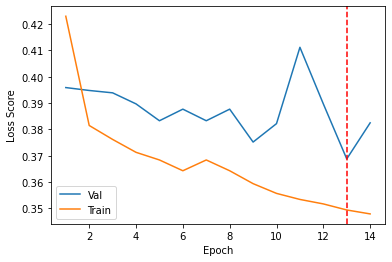

In [125]:
summary_df = pd.read_csv("loss.csv")
plt.plot(summary_df.epoch[summary_df.loss_type=="val"], summary_df.loss[summary_df.loss_type=="val"], label="Val")
plt.plot(summary_df.epoch[summary_df.loss_type=="train"], summary_df.loss[summary_df.loss_type=="train"], label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss Score")
plt.axvline(x=summary_df[summary_df.loss == np.min(summary_df[summary_df.loss_type == "val"].loss)].epoch.values, linestyle='--', color='r')
plt.legend()
plt.show()

## Find Real detections
Take cross-referenced (with optical) sources out of evaluation


Add filters (set to false detections) - and remove really false detections from optical overlay to save time:
- all spatial distributions below beam size and above 0.3Mpc
- all spectral filters lower than 7km/s and above 750 km/s 

- MTO very sensitive to diagonal lines

### Try to cross-match real detections along methods

TODO: install package

In [130]:
# new_sof_test = sofia_cat_df[sofia_cat_df.mos_name.str.contains("1245")]
# new_mto_test = mto_cat_df[mto_cat_df.mos_name.str.contains("1245")]
# new_vnet_test = vnet_cat_df[vnet_cat_df.mos_name.str.contains("1245")]
# set1 = set(new_sof_test[~new_sof_test.type.isnull()].mos_name + new_sof_test[~new_sof_test.type.isnull()].max_loc.astype(str))
# set2 = set(new_mto_test[~new_mto_test.type.isnull()].mos_name + new_mto_test[~new_mto_test.type.isnull()].max_loc.astype(str))
# set3 = set(new_vnet_test[~new_vnet_test.type.isnull()].mos_name + new_vnet_test[~new_vnet_test.type.isnull()].max_loc.astype(str))

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, facecolor="white", figsize=(20, 20))
# ax1.set_title("Real Detections", fontsize=18)
# out = venn3([set1, set2, set3], ('SoFiA', 'MTO', 'VNET'), ax=ax1)
# for text in out.set_labels:
#     text.set_fontsize(16)
# for text in out.subset_labels:
#     text.set_fontsize(16)

# set1 = set(new_sof_test[new_sof_test.true_positive_mocks].mos_name + new_sof_test[new_sof_test.true_positive_mocks].max_loc.astype(str))
# set2 = set(new_mto_test[new_mto_test.true_positive_mocks].mos_name + new_mto_test[new_mto_test.true_positive_mocks].max_loc.astype(str))
# set3 = set(new_vnet_test[new_vnet_test.true_positive_mocks].mos_name + new_vnet_test[new_vnet_test.true_positive_mocks].max_loc.astype(str))

# ax2.set_title("Mock Detections", fontsize=18)
# out = venn3([set1, set2, set3], ('SoFiA', 'MTO', 'VNET'), ax=ax2)
# for text in out.set_labels:
#     text.set_fontsize(16)
# for text in out.subset_labels:
#     text.set_fontsize(16)

# set1 = set(new_sof_test[~new_sof_test.true_positive_mocks & new_sof_test.type.isnull()].mos_name + new_sof_test[~new_sof_test.true_positive_mocks & new_sof_test.type.isnull()].max_loc.astype(str))
# set2 = set(new_mto_test[~new_mto_test.true_positive_mocks & new_mto_test.type.isnull()].mos_name + new_mto_test[~new_mto_test.true_positive_mocks & new_mto_test.type.isnull()].max_loc.astype(str))
# set3 = set(new_vnet_test[~new_vnet_test.true_positive_mocks & new_vnet_test.type.isnull()].mos_name + new_vnet_test[~new_vnet_test.true_positive_mocks & new_vnet_test.type.isnull()].max_loc.astype(str))

# ax3.set_title("False Detections", fontsize=18)
# out = venn3([set1, set2, set3], ('SoFiA', 'MTO', 'VNET'), ax=ax3)
# for text in out.set_labels:
#     text.set_fontsize(16)
# for text in out.subset_labels:
#     text.set_fontsize(16)
# ax1.text(0, -0.9, '(a)', fontsize=20, horizontalalignment='center')
# ax2.text(0, -0.9, '(b)', fontsize=20, horizontalalignment='center')
# ax3.text(0, -0.97, '(c)', fontsize=20, horizontalalignment='center')
# plt.show()

- MTO picks up by far most nonsense of all methods, particularly far away (mistaking noise for sources)
- VNET picks up more nonsense far away (mistaking noise for sources)
- SoFiA picks up more nonsense from nearby (from MW hi emission)
- VNET finds more mocks, then SoFiA, then MTO
- SoFiA finds more real galaxies (as expected, as VNET trains on mocks) and MTO the least
- Maybe SoFiA has some sort of bias or filtering that makes it struggle to find sources in the nearest cub

In [128]:
# from PIL import Image
# fig, ax1 = plt.subplots(1, 3, figsize=(10, 10))
# sof_image = Image.open('SOFIA_1245mosC_66.png')
# mto_image = Image.open('MTO_1245mosC_996.png')
# vnet_image = Image.open('VNET_1245mosC_283.png')
# ax1[0].imshow(sof_image.crop((10, 4, 204-15, 219-10)))
# ax1[1].imshow(mto_image.crop((10, 4, 204-15, 219-10)))
# ax1[2].imshow(vnet_image.crop((10, 4, 204-15, 219-10)))
# # ax1.axis('off')
# ax1[0].set_xticks([])
# ax1[0].set_yticks([])
# ax1[1].set_xticks([])
# ax1[1].set_yticks([])
# ax1[2].set_xticks([])
# ax1[2].set_yticks([])
# ax1[1].set_xlabel("(a)                                           (b)                                           (c)", fontsize=16)
# fig.tight_layout(pad=-1)


In [179]:
mto_cat_df[(mto_cat_df.mos_name.str.contains("1245")) & (mto_cat_df.type == "mock")]

,label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,...,overlap_areas,area_gts,hi_mass,true_positive_mocks,type,tot_flux,peak_flux,area_gt,overlap_area,f1
4,5,44.576000,158.504000,780.261000,33,151,775,58,167,785,...,NaN,NaN,4.810463e+10,True,mock,3.683281,0.119895,2327.0,987.0,0.843590
18,19,91.342239,356.590331,1267.417303,74,350,1264,108,365,1272,...,NaN,NaN,2.159234e+10,True,mock,1.728551,0.063899,3361.0,786.0,0.467718
19,20,101.427368,594.978947,585.033684,89,590,582,116,600,589,...,NaN,NaN,1.560192e+10,True,mock,1.261044,0.065647,2603.0,475.0,0.364964
20,21,101.950000,187.533333,750.483333,100,185,749,106,191,753,...,NaN,NaN,3.693398e+09,False,mock,0.298524,0.033394,2904.0,60.0,0.041322
31,32,168.589342,257.817137,868.998955,162,251,863,176,265,876,...,NaN,NaN,3.149670e+10,True,mock,2.718218,0.060346,1700.0,956.0,1.124045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6102,143,632.025165,652.057519,1290.905932,616,644,1284,652,661,1297,...,NaN,NaN,1.067885e+10,True,mock,3.764572,0.087619,5016.0,1669.0,0.665470
6105,146,637.718644,448.728814,1197.806780,627,446,1194,651,452,1203,...,NaN,NaN,2.235901e+09,True,mock,0.796195,0.045466,3116.0,295.0,0.189345
6106,147,635.740000,341.320000,605.322500,630,337,601,641,347,611,...,NaN,NaN,3.508706e+09,True,mock,1.244403,0.043359,1637.0,400.0,0.488699
6108,149,640.056075,224.859813,1062.981308,633,220,1061,647,230,1067,...,NaN,NaN,2.926572e+09,True,mock,1.048485,0.052978,2269.0,321.0,0.282944


TODO:
- map to mock galaxy ground truth
- compare hi mass and properties
- map mock galaxies across each method to create a "golden record" catlogue for comparing fluxes

In [518]:
mto_cat_df["log10mass"] = np.log10(mto_cat_df.hi_mass)
vnet_cat_df["log10mass"] = np.log10(vnet_cat_df.hi_mass)
sofia_cat_df["log10mass"] = np.log10(sofia_cat_df.hi_mass)
mask_cat_df["log10mass"] = np.log10(mass_cat_df.new_mass)

C:\Progra~1\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Progra~1\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [133]:
max_locs1 = mask_cat_df.max_loc.str.replace("]", "").str.replace("[", "").str.split(", ", expand=True)
max_locs1.columns = ["max_loc_z", "max_loc_x", "max_loc_y"]
mask_cat_df = mask_cat_df.join(max_locs1)

max_locs2 = sofia_cat_df.max_loc.str.replace("]", "").str.replace("[", "").str.split(", ", expand=True)
max_locs2.columns = ["max_loc_z", "max_loc_x", "max_loc_y"]
sofia_cat_df = sofia_cat_df.join(max_locs2)

In [135]:
mask_cat_df[mask_cat_df.mos_name.str.contains("1245mosC") & (mask_cat_df.type == "mock")][['mos_name', 'max_loc_z', 'max_loc_x', 'max_loc_y', 'label', 'type']]

,mos_name,max_loc_z,max_loc_x,max_loc_y,label,type
40,1245mosC,13,122,611,1,mock
41,1245mosC,38,157,831,2,mock
42,1245mosC,20,234,1248,3,mock
43,1245mosC,13,283,1052,4,mock
44,1245mosC,19,287,425,5,mock
...,...,...,...,...,...,...
329,1245mosC,613,442,285,290,mock
330,1245mosC,618,499,519,291,mock
331,1245mosC,620,546,34,292,mock
332,1245mosC,623,230,260,293,mock


In [101]:
pd.merge(mask_cat_df, x, on=["mos_name", "max_loc"], how='inner', suffixes=("_gt", "_mto"))

,index,label_gt,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,...,max_loc,dist,nx_kpc,ny_kpc,fluxes,type_gt,mos_name,log10mass,label_mto,type_mto


In [78]:
x

,mos_name,max_loc,label,type
4,1245mosE,"[53, 156, 781]",5,mock
18,1245mosE,"[106, 359, 1268]",19,mock
19,1245mosE,"[110, 597, 584]",20,mock
20,1245mosE,"[102, 188, 750]",21,mock
31,1245mosE,"[171, 256, 868]",32,mock
...,...,...,...,...
6102,1245mosD,"[620, 651, 1289]",143,mock
6105,1245mosD,"[631, 449, 1200]",146,mock
6106,1245mosD,"[635, 341, 605]",147,mock
6108,1245mosD,"[636, 224, 1063]",149,mock


In [67]:
mask_and_mto = pd.merge(mask_cat_df, mto_cat_df[~mto_cat_df.type.isnull()][['mos_name', 'max_loc', 'label']], on=['mos_name', 'max_loc', 'type'], how='left', suffixes=("_gt", "_mto"))
mask_and_mto_and_sofia = pd.merge(mask_and_mto, sofia_cat_df[~sofia_cat_df.type.isnull()][['mos_name', 'max_loc', 'label']], on=['mos_name', 'max_loc', 'type'], how='left')
mask_and_mto_and_sofia_and_vnet = pd.merge(mask_and_mto_and_sofia, vnet_cat_df[~vnet_cat_df.type.isnull()][['mos_name', 'max_loc', 'label']], on=['mos_name', 'max_loc', 'type'], suffixes=("_sofia", "_vnet"), how='left')
test_df = mask_and_mto_and_sofia_and_vnet[mask_and_mto_and_sofia_and_vnet.mos_name.str.contains("1245")]

KeyError: 'type'

In [59]:
for row in mask_cat_df.iterrows()

,index,label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,...,max_loc-1,max_loc-2,max_loc,dist,nx_kpc,ny_kpc,fluxes,type,mos_name,log10mass
0,0,1,52.025974,440.103896,1140.558442,51,436,1138,54,445,...,5,2,"[52, 441, 1140]",116.019573,30.373855,16.874363,"[0.8535388706307132, 0.07782847640953006]",real,1245mosC,0.977946
1,1,2,180.025974,440.324675,1140.363636,179,437,1138,182,445,...,4,2,"[180, 441, 1140]",101.160253,23.541061,14.713163,"[0.8648666671146084, 0.07841101219521679]",real,1245mosC,0.946677
2,2,3,285.509934,321.423841,118.211921,283,317,114,289,325,...,3,4,"[286, 320, 118]",89.045713,20.721879,25.902349,"[1.2547922905086828, 0.07249053008951814]",real,1245mosC,0.961938
3,3,4,308.066667,440.466667,1140.346667,307,437,1138,310,445,...,4,2,"[308, 441, 1140]",86.400986,20.106423,12.566514,"[0.8386221658900959, 0.07674786699194634]",real,1245mosC,0.942531
4,4,5,348.748507,393.704478,1084.443284,339,387,1080,359,401,...,6,5,"[352, 393, 1085]",81.809075,33.316216,26.177026,"[0.8133499608577356, 0.03559922709256194]",real,1245mosC,0.945039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,296,296,645.352878,704.320896,961.343284,638,698,958,652,711,...,6,3,"[643, 704, 961]",384.064391,145.235754,89.375846,"[1.2814627771502524e-05, 6.326923501982745e-07]",mock,1353mosH,NaN
3857,297,297,646.308068,929.546455,246.539120,640,923,243,652,936,...,6,3,"[650, 929, 246]",383.933284,145.186175,89.345336,"[2.3908227279649056e-05, 1.1525210689034995e-06]",mock,1353mosH,NaN
3858,298,298,646.287273,818.376970,205.472727,641,812,202,652,826,...,6,3,"[650, 818, 205]",383.933284,156.354344,89.345336,"[3.085701567726343e-05, 1.6152577218347902e-06]",mock,1353mosH,NaN
3859,299,299,647.536364,586.478788,910.330303,643,580,907,652,594,...,6,3,"[648, 586, 910]",383.802185,156.300954,89.314828,"[3.379865355641073e-05, 1.6567144523141961e-06]",mock,1353mosH,NaN


In [58]:

mock_mask_row = mock_mask_df[(mock_mask_df.max_loc.astype(str) == str(row.max_loc)) & (mock_mask_df.mos_name == row.mos_name)]
real_mask_row = real_mask_df[(real_mask_df.max_loc.astype(str) == str(row.max_loc)) & (real_mask_df.mos_name == row.mos_name)]

NameError: name 'mock_mask_df' is not defined

In [56]:
pd.merge(mask_cat_df, mto_cat_df[(mto_cat_df.type == "mock") & (mto_cat_df.mos_name.str.contains("1245"))][['mos_name', 'max_loc', 'label']], on=['mos_name', 'max_loc'], how='right', suffixes=("_gt", "_mto"))

,index,label_gt,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,...,max_loc-2,max_loc,dist,nx_kpc,ny_kpc,fluxes,type,mos_name,log10mass,label_mto
0,45.0,6.0,27.514448,489.729019,478.784968,0.0,482.0,468.0,56.0,499.0,...,14.0,"[50, 490, 482]",118.933551,58.813831,76.112021,"[0.002595558215548276, 4.4612669383221865e-05]",mock,1245mosC,0.949048,3
1,62.0,23.0,34.705882,787.808915,1052.784801,23.0,778.0,1047.0,47.0,799.0,...,5.0,"[41, 790, 1052]",118.117248,72.153731,44.666592,"[0.0013865313876130119, 3.775062196416014e-05]",mock,1245mosC,0.941376,11
2,63.0,24.0,29.661882,60.816587,1114.769537,24.0,53.0,1109.0,36.0,70.0,...,5.0,"[29, 61, 1114]",118.700290,58.698481,44.887072,"[0.0005855655255839013, 1.7614316867077137e-05]",mock,1245mosC,1.010625,12
3,69.0,30.0,54.696732,94.779698,844.783784,39.0,87.0,838.0,72.0,104.0,...,9.0,"[43, 95, 847]",115.786622,57.257643,50.521449,"[0.0007468141816796968, 2.110758143635718e-05]",mock,1245mosC,0.949792,34
4,72.0,33.0,63.713816,771.265461,460.277303,50.0,763.0,453.0,79.0,780.0,...,5.0,"[72, 771, 458]",114.738645,56.739408,53.401796,"[0.001178040478135408, 2.766485453776081e-05]",mock,1245mosC,0.961808,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"[614, 201, 170]",NaN,NaN,NaN,NaN,NaN,1245mosD,NaN,142
318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"[631, 449, 1200]",NaN,NaN,NaN,NaN,NaN,1245mosD,NaN,146
319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"[635, 341, 605]",NaN,NaN,NaN,NaN,NaN,1245mosD,NaN,147
320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"[636, 224, 1063]",NaN,NaN,NaN,NaN,NaN,1245mosD,NaN,149


In [62]:
pd.merge(mask_cat_df, mto_cat_df[(mto_cat_df.type == "mock") & (mto_cat_df.mos_name.str.contains("1245"))][['mos_name', 'max_loc', 'type']], on=['mos_name', 'max_loc'], how='left', suffixes=("_gt", "_mto"))

,index,label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,...,max_loc-2,max_loc,dist,nx_kpc,ny_kpc,fluxes,type_gt,mos_name,log10mass,type_mto
0,0,1,52.025974,440.103896,1140.558442,51,436,1138,54,445,...,2,"[52, 441, 1140]",116.019573,30.373855,16.874363,"[0.8535388706307132, 0.07782847640953006]",real,1245mosC,0.977946,NaN
1,1,2,180.025974,440.324675,1140.363636,179,437,1138,182,445,...,2,"[180, 441, 1140]",101.160253,23.541061,14.713163,"[0.8648666671146084, 0.07841101219521679]",real,1245mosC,0.946677,NaN
2,2,3,285.509934,321.423841,118.211921,283,317,114,289,325,...,4,"[286, 320, 118]",89.045713,20.721879,25.902349,"[1.2547922905086828, 0.07249053008951814]",real,1245mosC,0.961938,NaN
3,3,4,308.066667,440.466667,1140.346667,307,437,1138,310,445,...,2,"[308, 441, 1140]",86.400986,20.106423,12.566514,"[0.8386221658900959, 0.07674786699194634]",real,1245mosC,0.942531,NaN
4,4,5,348.748507,393.704478,1084.443284,339,387,1080,359,401,...,5,"[352, 393, 1085]",81.809075,33.316216,26.177026,"[0.8133499608577356, 0.03559922709256194]",real,1245mosC,0.945039,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,296,296,645.352878,704.320896,961.343284,638,698,958,652,711,...,3,"[643, 704, 961]",384.064391,145.235754,89.375846,"[1.2814627771502524e-05, 6.326923501982745e-07]",mock,1353mosH,NaN,NaN
3857,297,297,646.308068,929.546455,246.539120,640,923,243,652,936,...,3,"[650, 929, 246]",383.933284,145.186175,89.345336,"[2.3908227279649056e-05, 1.1525210689034995e-06]",mock,1353mosH,NaN,NaN
3858,298,298,646.287273,818.376970,205.472727,641,812,202,652,826,...,3,"[650, 818, 205]",383.933284,156.354344,89.345336,"[3.085701567726343e-05, 1.6152577218347902e-06]",mock,1353mosH,NaN,NaN
3859,299,299,647.536364,586.478788,910.330303,643,580,907,652,594,...,3,"[648, 586, 910]",383.802185,156.300954,89.314828,"[3.379865355641073e-05, 1.6567144523141961e-06]",mock,1353mosH,NaN,NaN


In [53]:
test_df[(~test_df.label_mto.isnull() ) & (test_df.type == "mock")]

,index,label_gt,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,...,dist,nx_kpc,ny_kpc,fluxes,type,mos_name,log10mass,label_mto,label_sofia,label_vnet
45,45,6,27.514448,489.729019,478.784968,0,482,468,56,499,...,118.933551,58.813831,76.112021,"[0.002595558215548276, 4.4612669383221865e-05]",mock,1245mosC,0.949048,3.0,336.0,8.0
62,62,23,34.705882,787.808915,1052.784801,23,778,1047,47,799,...,118.117248,72.153731,44.666592,"[0.0013865313876130119, 3.775062196416014e-05]",mock,1245mosC,0.941376,11.0,341.0,23.0
63,63,24,29.661882,60.816587,1114.769537,24,53,1109,36,70,...,118.700290,58.698481,44.887072,"[0.0005855655255839013, 1.7614316867077137e-05]",mock,1245mosC,1.010625,12.0,348.0,22.0
69,69,30,54.696732,94.779698,844.783784,39,87,838,72,104,...,115.786622,57.257643,50.521449,"[0.0007468141816796968, 2.110758143635718e-05]",mock,1245mosC,0.949792,34.0,329.0,27.0
72,72,33,63.713816,771.265461,460.277303,50,763,453,79,780,...,114.738645,56.739408,53.401796,"[0.001178040478135408, 2.766485453776081e-05]",mock,1245mosC,0.961808,42.0,319.0,31.0
98,98,59,106.648768,795.282909,1317.253857,87,780,1311,127,811,...,109.738531,98.957128,41.498141,"[0.004982822295333076, 8.547801958311403e-05]",mock,1245mosC,1.009115,54.0,288.0,56.0
102,102,63,102.711790,617.252481,1366.268757,92,608,1358,114,628,...,110.203178,64.113619,54.496574,"[0.0016715440268534752, 3.794241198892212e-05]",mock,1245mosC,0.941114,57.0,296.0,61.0
128,128,89,170.662787,94.262954,340.260737,155,86,332,187,104,...,102.317521,53.573335,50.597038,"[0.0013866486642420748, 2.9235793492935018e-05]",mock,1245mosC,0.981955,82.0,263.0,85.0
149,149,110,227.703545,547.730752,813.744976,206,522,800,250,574,...,95.729264,144.801988,77.970259,"[0.01613774442347671, 0.00010933750473544762]",mock,1245mosC,0.971649,95.0,228.0,106.0
163,163,124,232.694165,388.226358,255.240443,229,380,249,238,397,...,95.152291,47.053760,35.982286,"[0.00045219703022860493, 1.5221962207966382e-05]",mock,1245mosC,0.980821,120.0,240.0,121.0


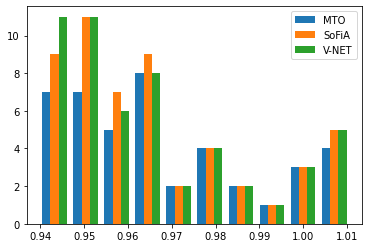

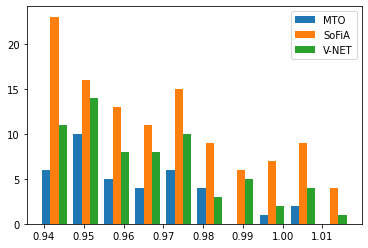

In [49]:
plt.hist([
    test_df[(~test_df.label_mto.isnull() ) & (test_df.type == "mock")].log10mass,
    test_df[(~test_df.label_sofia.isnull()) & (test_df.type == "mock")].log10mass,
    test_df[(~test_df.label_vnet.isnull()) & (test_df.type == "mock")].log10mass
],
label=["MTO", "SoFiA", "V-NET"])
plt.legend()
plt.show()

plt.hist([
    test_df[(~test_df.label_mto.isnull() ) & (test_df.type == "real")].log10mass,
    test_df[(~test_df.label_sofia.isnull()) & (test_df.type == "real")].log10mass,
    test_df[(~test_df.label_vnet.isnull()) & (test_df.type == "real")].log10mass
],
label=["MTO", "SoFiA", "V-NET"])
plt.legend()
plt.show()

(array([[900., 716., 618., 472., 350., 233., 211.,  67.,  33.,   0.],
        [211., 832., 669., 615., 460., 316., 244., 163.,  61.,  29.]]),
 array([ 8.5004    ,  8.71453479,  8.92866957,  9.14280436,  9.35693914,
         9.57107393,  9.78520871,  9.9993435 , 10.21347828, 10.42761307,
        10.64174786]),
 <a list of 2 Lists of Patches objects>)

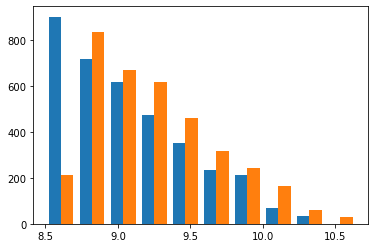

In [164]:
plt.hist([mass_cat_df.orig_mass, mass_cat_df.new_mass])

In [135]:
real_gals = pd.merge(mto_cat_df[(mto_cat_df.type == "real") & (mto_cat_df.mos_name.str.contains("1245"))], pd.merge(sofia_cat_df[(sofia_cat_df.type =="real") & (sofia_cat_df.mos_name.str.contains("1245"))], vnet_cat_df[(vnet_cat_df.type == "real") & (vnet_cat_df.mos_name.str.contains("1245"))], on=['mos_name', 'max_loc'], how='outer', suffixes=("_sofia", "_vnet")), on=['mos_name', 'max_loc'], how='outer')
overlap_real = real_gals[~real_gals.type.isnull() & ~real_gals.type_vnet.isnull() & ~real_gals.type_sofia.isnull()]
overlap_real.groupby("mos_name").count()

,label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,...,overlap_areas_vnet,area_gts_vnet,hi_mass_vnet,true_positive_mocks_vnet,type_vnet,area_gt_vnet,overlap_area_vnet,tot_flux_vnet,peak_flux_vnet,f1_vnet
mos_name,,,,,,,,,,,,,,,,,,,,,
1245mosC,10,10,10,10,10,10,10,10,10,10,...,0,0,9,10,10,10,10,9,9,10
1245mosD,7,7,7,7,7,7,7,7,7,7,...,0,0,7,7,7,7,7,7,7,7
1245mosE,5,5,5,5,5,5,5,5,5,5,...,0,0,5,5,5,5,5,5,5,5
1245mosG,3,3,3,3,3,3,3,3,3,3,...,0,0,3,3,3,3,3,3,3,3


In [136]:
overlap_real = overlap_real.sort_values("dist")
plt.scatter(np.arange(0, len(overlap_real.asymmetry)), overlap_real.asymmetry_sofia, label="SoFiA", marker='^')
plt.scatter(np.arange(0, len(overlap_real.asymmetry)), overlap_real.asymmetry, label="MTO", marker='v')
plt.scatter(np.arange(0, len(overlap_real.asymmetry)), overlap_real.asymmetry_vnet, label="VNET", marker='o')
plt.scatter(np.where(overlap_real.label_sofia == 66)[0], overlap_real[overlap_real.label_sofia == 66].asymmetry_sofia, marker="x", s=100, color='r')
plt.scatter(np.where(overlap_real.label_sofia == 66)[0], overlap_real[overlap_real.label_sofia == 66].asymmetry_vnet, marker="x", s=100, color='r')
plt.scatter(np.where(overlap_real.label_sofia == 66)[0], overlap_real[overlap_real.label_sofia == 66].asymmetry, marker="x", s=100, color='r')
plt.ylabel("Asymmetry", fontsize=12)
plt.xlabel("Overlapping detection", fontsize=12)
plt.legend(loc="upper right")
plt.xticks(np.arange(0, len(overlap_real.asymmetry)), labels=[])

plt.grid(which='both', axis="x", alpha=0.6, linestyle='--')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'asymmetry'

/tmp/ipykernel_19130/4031363220.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(merged.index, rotation=45)


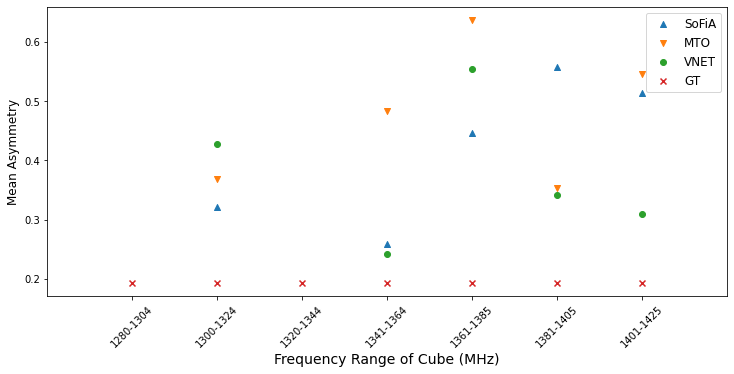

In [176]:
freq_labels = ['1279.96-1304', '1300.18-1324', '1320.39-1344', '1340.61-1364', '1360.82-1385', '1381.04-1405', '1401.25-1425']
fig, axes = plt.subplots(1, figsize=(10,5)) #, sharey=True, sharex=True)
# fig.suptitle("Mean properties galaxies detected in each cube", fontsize=15)
merged = pd.merge(df[['mos_name', 'freq_labels', 'freq_1']], overlap_real, on="mos_name", how="right").groupby('freq_labels').mean()
merged = merged.reindex(merged.index.values.tolist()+['1280-1304', '1320-1344']).sort_values("freq_labels")
axes.set_xticklabels(merged.index, rotation=45)
axes.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
axes.scatter(merged.index, merged.asymmetry_sofia, label="SoFiA", marker='^')
axes.scatter(merged.index, merged.asymmetry, label="MTO", marker='v')
axes.scatter(merged.index, merged.asymmetry_vnet, label="VNET", marker='o')
mask = pd.merge(df[['mos_name', 'freq_labels', 'freq_1']], mask_cat_df[mask_cat_df.mos_name.str.contains("1245")], on="mos_name", how="right").groupby('freq_labels').mean()
axes.scatter(mask.index, mask.asymmetry, label="GT", marker='x')
axes.set_ylabel("Mean Asymmetry", fontsize=12)

axes.legend(fontsize=12)
axes.set_xlim(-1, len(merged.index))
fig.tight_layout(pad=0)

## Investigate False detections

In [137]:
d_channels = 36621.09375*u.Hz
spec_range = {row.mos_name: np.arange(row.freq_1, row.freq_2, d_channels.value) for i, row in df.iterrows()}
new_sof['freq'] = [spec_range[row.mos_name][int(row['centroid-0'])] for i, row in new_sof.iterrows()]
new_vnet['freq'] = [spec_range[row.mos_name][int(row['centroid-0'])] for i, row in new_vnet.iterrows()]
new_mto['freq'] = [spec_range[row.mos_name][int(row['centroid-0'])] for i, row in new_mto.iterrows()]
fig, axes = plt.subplots(3, 7, figsize=(20, 10), facecolor='white')
fig.suptitle("False Detections")
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']
for j, method in enumerate([new_sof, new_vnet, new_mto]):
    for i, mos_name in enumerate(np.sort(new_sof_test.mos_name.unique())):
            methodhist = method[(method.mos_name==mos_name) & method.type.isnull() & ~method.true_positive_mocks].freq
            axes[j][i].hist(methodhist, color=colors[j], alpha=0.7)
            if j == 0:
                axes[j][i].set_title(mos_name)
            elif j == 2:
                axes[j][i].set_xlabel("Frequency (Hz)")
#             axes[j][i].set_ylabel("Number of false detetcions")
axes[0][0].set_ylabel("SoFiA", fontsize=14)
axes[1][0].set_ylabel("VNET", fontsize=14)
axes[2][0].set_ylabel("MTO", fontsize=14)
fig.tight_layout()

NameError: name 'new_sof' is not defined

- Emission of MW HI gas around 1420 MHz misdetected by SoFiA and MTO in 1245mosB
- Low number of real sources for 1245mosB because at higher frequencies you look at the very nearby universe and the volume that is surveyed by that spectral window becomes relatively small in terms of cubic Mega-parsecs.
- It could also be that one of the 40 beams in the mosaic has poor imaging quality.



## Invetigate Real detections
HI mass and spatial elongation (of test set)

/home/jbarkai/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jbarkai/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jbarkai/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jbarkai/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


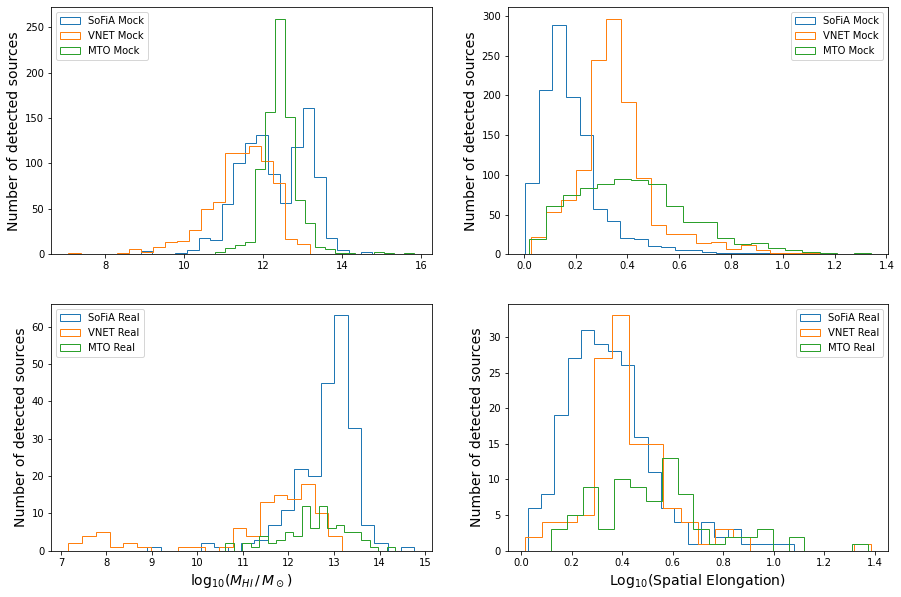

In [178]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15,10))
sof_mock_phi = new_sof_test[new_sof_test.true_positive_mocks]
vnet_mock_phi = new_vnet_test[new_vnet_test.true_positive_mocks]
sof_real_phi = new_sof_test[~new_sof_test.type.isnull()]
vnet_real_phi = new_vnet_test[~new_vnet_test.type.isnull()]
mto_mock_phi = new_mto_test[new_mto_test.true_positive_mocks]
mto_real_phi = new_mto_test[~new_mto_test.type.isnull()]

ax1[0].hist(np.log10(sof_mock_phi.hi_mass), label="SoFiA Mock", bins=20, histtype='step')
ax1[0].hist(np.log10(vnet_mock_phi.hi_mass),label="VNET Mock", bins=20, histtype='step')
ax2[0].hist(np.log10(sof_real_phi.hi_mass), label="SoFiA Real", bins=20, histtype='step')
ax2[0].hist(np.log10(vnet_real_phi.hi_mass),label="VNET Real", bins=20, histtype='step')
ax2[0].hist(np.log10(mto_real_phi.hi_mass), label="MTO Real", bins=20, histtype='step')
ax1[0].hist(np.log10(mto_mock_phi.hi_mass),label="MTO Mock", bins=20, histtype='step')

ax2[0].set_xlabel(r'$\log_{10}(M_{HI}\,/\,M_\odot)$', fontsize=14)
ax1[0].set_ylabel("Number of detected sources", fontsize=14)
ax2[0].set_ylabel("Number of detected sources", fontsize=14)
ax1[0].legend()
ax2[0].legend()

ax1[1].hist(np.log10(sof_mock_phi.elongation), label="SoFiA Mock", bins=20, histtype='step')
ax1[1].hist(np.log10(vnet_mock_phi.elongation),label="VNET Mock", bins=20, histtype='step')
ax2[1].hist(np.log10(sof_real_phi.elongation), label="SoFiA Real", bins=20, histtype='step')
ax2[1].hist(np.log10(vnet_real_phi.elongation),label="VNET Real", bins=20, histtype='step')
ax2[1].hist(np.log10(mto_real_phi.elongation[np.isfinite(np.log10(mto_real_phi.elongation))]), label="MTO Real", bins=20, histtype='step')
ax1[1].hist(np.log10(mto_mock_phi.elongation)[np.isfinite(np.log10(mto_mock_phi.elongation))],label="MTO Mock", bins=20, histtype='step')

ax2[1].set_xlabel(r'Log$_{10}$(Spatial Elongation)', fontsize=14)
ax1[1].set_ylabel("Number of detected sources", fontsize=14)
ax2[1].set_ylabel("Number of detected sources", fontsize=14)
ax1[0].legend()
ax2[0].legend()
ax1[1].legend()
ax2[1].legend()

- SoFiA detects more massive galaxies, then MTO, then VNET
- MTO picks up more elongated sources, then VNET, then SoFiA

## Evaluate with real detections removed

In [179]:
new_sof_cross = new_sof[new_sof.type.isnull() | new_sof.true_positive_mocks]
new_vnet_cross = new_vnet[new_vnet.type.isnull() | new_vnet.true_positive_mocks]
new_mto_cross = new_mto[new_mto.type.isnull() | new_mto.true_positive_mocks]

In [180]:
full_sofia_df = make_eval_df(new_sof_cross, mask_cat_df)
full_mto_df = make_eval_df(new_mto_cross, mask_cat_df)
full_vnet_df = make_eval_df(new_vnet_cross, mask_cat_df)

/tmp/ipykernel_19130/3467993067.py:43: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


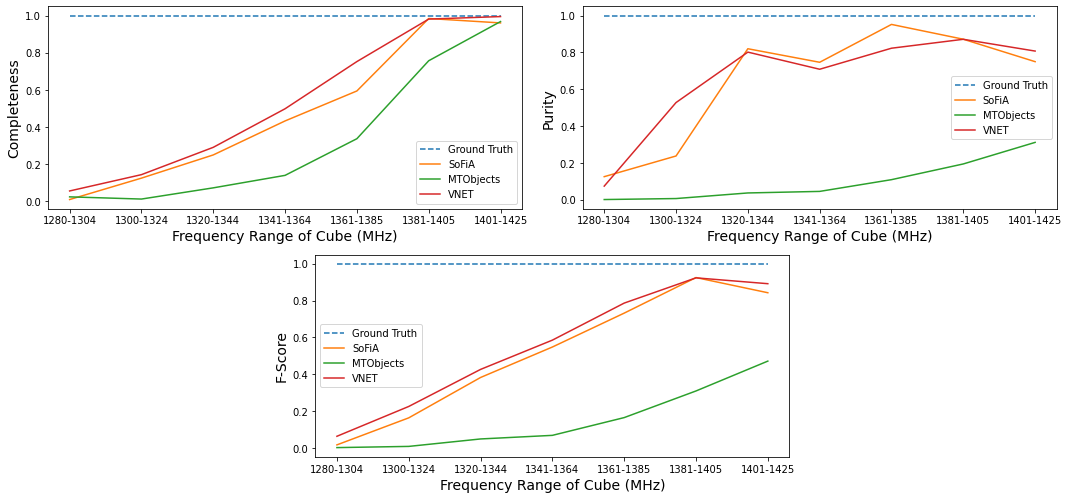

In [181]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))
gs = fig.add_gridspec(3, 4)
ax1 = fig.add_subplot(gs[0, :2])
ax1.set_ylabel("Completeness", fontsize=14)
ax1.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax1.plot([1]*7, label="Ground Truth", linestyle="--")
sof = full_sofia_df[full_sofia_df.mos_name.str.contains("1245")].sort_values('freq_labels')
mto = full_mto_df[full_mto_df.mos_name.str.contains("1245")].sort_values('freq_labels')
vnet = full_vnet_df[full_vnet_df.mos_name.str.contains("1245")].sort_values('freq_labels')
ax1.plot(sof.freq_labels, sof.recall, label="SoFiA")
ax1.plot(mto.freq_labels, mto.recall, label="MTObjects")
ax1.plot(vnet.freq_labels, vnet.recall, label="VNET")
ax1.legend()

ax2 = fig.add_subplot(gs[0, 2:4])

ax2.set_ylabel("Purity", fontsize=14)
ax2.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax2.plot([1]*7, label="Ground Truth", linestyle="--")
ax2.plot(sof.freq_labels, sof.precision, label="SoFiA")
ax2.plot(mto.freq_labels, mto.precision, label="MTObjects")
ax2.plot(vnet.freq_labels, vnet.precision, label="VNET")
ax2.legend()

ax5 = fig.add_subplot(gs[1, 1:3])
ax5.set_ylabel("F-Score", fontsize=14)
ax5.plot([1]*7, label="Ground Truth", linestyle="--")
ax5.plot(sof.freq_labels, sof.f_score, label="SoFiA")
ax5.plot(mto.freq_labels, mto.f_score, label="MTObjects")
ax5.plot(vnet.freq_labels, vnet.f_score, label="VNET")
ax5.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax5.legend()

# ax6 = fig.add_subplot(gs[1, 2:4])
# ax6.set_ylabel("Accuracy", fontsize=14)
# ax6.plot([1]*7, label="Ground Truth", linestyle="--")
# ax6.plot(sof.freq_labels, sof.accuracy, label="SoFiA")
# ax6.plot(mto.freq_labels, mto.accuracy, label="MTObjects")
# ax6.plot(vnet.freq_labels, vnet.accuracy, label="VNET")
# ax6.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
# ax6.legend()

fig.tight_layout()

## Investigate quality of mock masks
For test set

/tmp/ipykernel_19130/2941463676.py:22: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


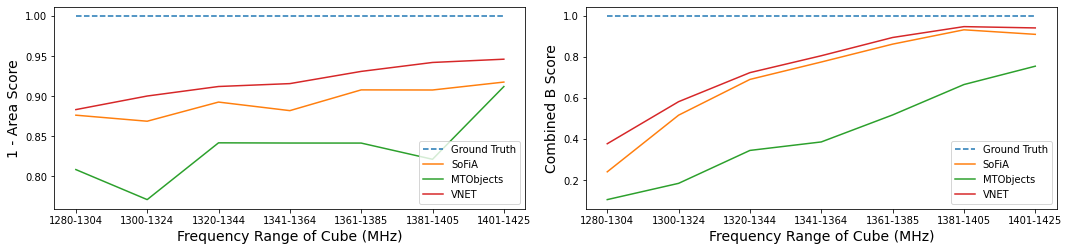

In [182]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))
gs = fig.add_gridspec(3, 4)

ax3 = fig.add_subplot(gs[1, :2])
ax3.set_ylabel("1 - Area Score", fontsize=14)
ax3.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax3.plot([1]*7, label="Ground Truth", linestyle="--")
ax3.plot(sof.freq_labels, 1 - sof.area_score, label="SoFiA")
ax3.plot(mto.freq_labels, 1 - mto.area_score, label="MTObjects")
ax3.plot(vnet.freq_labels, 1 - vnet.area_score, label="VNET")
ax3.legend()

ax4 = fig.add_subplot(gs[1, 2:4])
ax4.set_ylabel("Combined B Score", fontsize=14)
ax4.set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
ax4.plot([1]*7, label="Ground Truth", linestyle="--")
ax4.plot(sof.freq_labels, sof.combined_two, label="SoFiA")
ax4.plot(mto.freq_labels, mto.combined_two, label="MTObjects")
ax4.plot(vnet.freq_labels, vnet.combined_two, label="VNET")
ax4.legend()

fig.tight_layout()

In [170]:
sofia_cat_df

,label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,...,overlap_areas,area_gts,hi_mass,true_positive_mocks,type,area_gt,overlap_area,tot_flux,peak_flux,f1
0,1,646.780822,778.342466,674.684932,642,775,672,652,783,678,...,NaN,NaN,1.778571e+09,True,mock,1011.0,219.0,0.264136,0.018200,0.433234
1,2,640.335873,194.729978,387.434076,627,183,376,652,208,399,...,NaN,NaN,9.745592e+10,True,mock,4500.0,4111.0,14.360600,0.105437,1.119553
2,3,634.842350,67.002327,1368.792321,613,62,1365,652,73,1374,...,NaN,NaN,3.126593e+10,True,mock,7643.0,2917.0,4.571471,0.170351,0.905198
3,4,629.120900,245.011715,1198.723993,616,236,1193,646,252,1206,...,NaN,NaN,1.318450e+10,True,mock,2714.0,1994.0,1.915322,0.056890,1.397337
4,5,621.418622,514.213929,186.492012,602,507,178,641,522,197,...,NaN,NaN,4.556033e+10,True,mock,3296.0,2978.0,6.550790,0.117772,1.377428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253,226,4.730769,832.400000,840.407692,1,829,838,9,836,844,...,NaN,NaN,2.797993e+09,False,NaN,NaN,NaN,0.090826,0.010290,NaN
2254,227,4.784483,823.043103,11.689655,1,820,9,9,827,15,...,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
2255,228,5.304348,789.913043,166.489130,1,787,164,9,793,170,...,NaN,NaN,1.281965e+10,False,NaN,NaN,NaN,0.416394,0.040929,NaN
2256,229,5.413793,551.643678,1428.195402,3,549,1426,9,555,1431,...,NaN,NaN,1.739403e+09,False,NaN,NaN,NaN,0.056497,0.004813,NaN


KeyError: 'peak_flux'

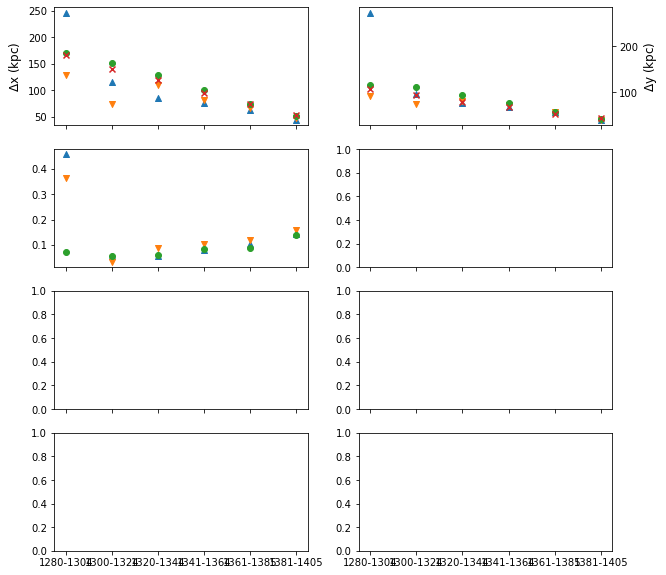

In [169]:
freq_labels = ['1279.96-1304', '1300.18-1324', '1320.39-1344', '1340.61-1364', '1360.82-1385', '1381.04-1405', '1401.25-1425']
fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True) #, sharey=True, sharex=True)
# fig.suptitle("Mean properties galaxies detected in each cube", fontsize=15)
i = 0
j = 0
labels = {"elongation": "Elongation", "peak_flux": "Peak Flux", "nx_kpc": r"$\Delta$x (kpc)", "ny_kpc": r"$\Delta$y (kpc)", "n_vel": r"$\Delta$v (km/s)", "tot_flux": "Total Flux", "asymmetry": "Asymmetry", "log10mass": r'$\log_{10}(M_{HI}\,/\,M_\odot)$'}
for col in ["nx_kpc", "ny_kpc", "peak_flux", "tot_flux", "n_vel", "log10mass", "asymmetry", "elongation"]:
    if i == 2:
        j += 1
        i = 0
    sof = pd.merge(freq_df[['mos_name', 'freq_labels', 'freq_1']], sofia_cat_df[sofia_cat_df.true_positive_mocks & sofia_cat_df.mos_name.str.contains("1245")], on="mos_name", how="right").groupby('freq_labels').mean()
    mto = pd.merge(freq_df[['mos_name', 'freq_labels', 'freq_1']], mto_cat_df[mto_cat_df.true_positive_mocks & mto_cat_df.mos_name.str.contains("1245")], on="mos_name", how="right").groupby('freq_labels').mean()
    vnet = pd.merge(freq_df[['mos_name', 'freq_labels', 'freq_1']], vnet_cat_df[vnet_cat_df.true_positive_mocks & vnet_cat_df.mos_name.str.contains("1245")], on="mos_name", how="right").groupby('freq_labels').mean()
    axes[j][i].scatter(sof.index, sof[col], label="SoFiA", marker='^')
    axes[j][i].scatter(mto.index, mto[col], label="MTO", marker='v')
    axes[j][i].scatter(vnet.index, vnet[col], label="VNET", marker='o')
    mask = pd.merge(freq_df[['mos_name', 'freq_labels', 'freq_1']], mask_cat_df[mask_cat_df.mos_name.str.contains("1245")], on="mos_name", how="right").groupby('freq_labels').mean()
    axes[j][i].scatter(mask.index, mask[col], label="GT", marker='x')
    axes[j][i].set_ylabel(labels[col], fontsize=12)
    if i == 1:
        axes[j][i].yaxis.set_label_position("right")
        axes[j][i].yaxis.tick_right()
    i += 1

axes[0][1].legend(loc=(1.2, 0.5), fontsize=12)
axes[3][0].set_xticklabels(sof.index, rotation=45)
axes[3][0].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
axes[3][1].set_xticklabels(sof.index, rotation=45)
axes[3][1].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
fig.tight_layout(pad=0)

- SoFiA picking up a lot of nonsense in 1245mosB due to MW emission and nonsense at far cubes, need more rigourous way to cross-match than just max-loc
- $\Delta v$ is the most poorly estimated by all, getting worse with distance except last one because so few detected by VNET and MTO

# Experiment 2
- Train machine learning to classify false positives

Create classified catalog

In [185]:
sof_cat = new_sof[['mos_name', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'true_positive_mocks', 'hi_mass', 'type']]
sof_cat["Class"] = 0
sof_cat.loc[sof_cat.true_positive_mocks | ~sof_cat.type.isnull(), "Class"] = 1
sof_cat["method"] = "sofia"
sof_cat = sof_cat[['mos_name', 'method', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass', 'Class']]
mto_cat = new_mto[['mos_name', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'true_positive_mocks', 'hi_mass', 'type']]
mto_cat["Class"] = 0
mto_cat.loc[mto_cat.true_positive_mocks | ~mto_cat.type.isnull(), "Class"] = 3
mto_cat["method"] = "mto"
mto_cat = mto_cat[['mos_name', 'method', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass', 'Class']]
vnet_cat = new_vnet[['mos_name', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'true_positive_mocks', 'hi_mass', 'type']]
vnet_cat["Class"] = 0
vnet_cat.loc[vnet_cat.true_positive_mocks | ~vnet_cat.type.isnull(), "Class"] = 2
vnet_cat["method"] = "vnet"
vnet_cat = vnet_cat[['mos_name', 'method', 'area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass', 'Class']]
full_cat = sof_cat.append(vnet_cat).append(mto_cat)

/tmp/ipykernel_19130/1992725130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sof_cat["Class"] = 0
/home/jbarkai/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_19130/1992725130.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

## Train ML to identify tps
- train and evaluate ML methods with train set (1353)
- use best model to predict class of test set (1245)
- remove detections from catalogs for evaluation that were predicted to be false

In [186]:
tree_model = tree.DecisionTreeClassifier(max_depth=12, class_weight='balanced')
rf = RandomForestClassifier(class_weight='balanced', max_depth=12) 
svm_model = SVC(class_weight='balanced')
knn_model = KNeighborsClassifier(n_neighbors=1)
models = [tree_model, rf, svm_model, knn_model]
# model_names = ["Decision Tree", "Random Forrests", "Support Vector Classification", "K Nearest Neighbours", "Logistic Regression", "Gaussian Naive Bayes"]

In [187]:
full_cat = full_cat[~full_cat.elongation.isnull() & ~full_cat.hi_mass.isnull() & np.isfinite(full_cat.elongation)]
full_cat = full_cat[full_cat.mos_name.str.contains("1353")]
x_train = full_cat[full_cat.mos_name.str.contains("1353")][['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass']]
x_test = full_cat[full_cat.mos_name.str.contains("1245")][['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
       'nx_kpc', 'ny_kpc', 'hi_mass']]
y_train = full_cat[full_cat.mos_name.str.contains("1353")].Class.astype(int)
y_test = full_cat[full_cat.mos_name.str.contains("1245")].Class.astype(int)

# Under sample MTO fp and over sample MTO tp

In [ ]:
new_full_cat = full_cat[(full_cat.Class != 0) & (full_cat.Class != 1) & ( full_cat.mos_name.str.contains("H"))]
oversample = SMOTE()
X, y = oversample.fit_resample(new_full_cat[['area', 'tot_flux', 'peak_flux', 'elongation',
       'n_vel', 'nx_kpc', 'ny_kpc', 'hi_mass']], new_full_cat.Class)

X["Class"] = y
X["mos_name"] = "1353mosH"
X["method"] = "mto"
mto_oversample = pd.concat([new_full_cat[new_full_cat.Class == 3], X[X.Class == 3]]).drop_duplicates().reset_index(drop=True)


new_full_cat = full_cat[(full_cat.Class == 0) & (full_cat.method !="sofia") & (full_cat.mos_name.str.contains("H"))]
new_full_cat.Class = new_full_cat.method.map({"vnet":2, "mto":3})

undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(new_full_cat[['area', 'tot_flux', 'peak_flux', 'elongation',
       'n_vel', 'nx_kpc', 'ny_kpc', 'hi_mass']], new_full_cat.Class)
X["method"] = y.map({2:"vnet", 3:"mto"})
X["mos_name"] = "1353mosH"
X["Class"] = 0
mto_undersample = X[X.method == "mto"]

train_set = full_cat[~((full_cat.method == "mto") & (full_cat.Class == 0) & (full_cat.mos_name == "1353mosH"))]
train_set = train_set.append(mto_undersample)
train_set = train_set[~((train_set.method == "mto") & (train_set.Class != 0) & (train_set.mos_name == "1353mosH"))]
train_set = train_set.append(mto_oversample)
train_set.loc[train_set.Class != 0, "Class"] = 1
x_train = train_set[['area', 'tot_flux', 'peak_flux', 'elongation',
       'n_vel', 'nx_kpc', 'ny_kpc', 'hi_mass']]
y_train = train_set.Class

In [ ]:
sof_precision = []
mto_precision = []
vnet_precision = []
sof_recall = []
mto_recall = []
vnet_recall = []

for model in models:
    print(model)
    before = datetime.now()
    model.fit(x_train, y_train)
    after = datetime.now()
    difference = (after - before).total_seconds()
    print("training time =", difference)
    ml_new_sof = new_sof_test[~new_sof_test.elongation.isnull() & ~new_sof_test.hi_mass.isnull() & np.isfinite(new_sof_test.elongation)].copy(deep=True)
    before = datetime.now()
    ml_new_sof["prediction"] = model.predict(ml_new_sof[['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
           'nx_kpc', 'ny_kpc', 'hi_mass']])
    after = datetime.now()
    difference = (after - before).total_seconds()
    print("inference time =", difference)
    ml_new_sof = ml_new_sof[ml_new_sof.prediction == 1]
    ml_new_sof = ml_new_sof[ml_new_sof.type.isnull()]

    ml_new_mto = new_mto_test[~new_mto_test.elongation.isnull() & ~new_mto_test.hi_mass.isnull() & np.isfinite(new_mto_test.elongation)].copy(deep=True)
    ml_new_mto["prediction"] = model.predict(ml_new_mto[['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
           'nx_kpc', 'ny_kpc', 'hi_mass']])
    ml_new_mto = ml_new_mto[ml_new_mto.prediction == 1]
    ml_new_mto = ml_new_mto[ml_new_mto.type.isnull()]

    ml_new_vnet = new_vnet_test[~new_vnet_test.elongation.isnull() & ~new_vnet_test.hi_mass.isnull() & np.isfinite(new_vnet_test.elongation)].copy(deep=True)
    ml_new_vnet["prediction"] = model.predict(ml_new_vnet[['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
           'nx_kpc', 'ny_kpc', 'hi_mass']])
    ml_new_vnet = ml_new_vnet[ml_new_vnet.prediction == 1]
    ml_new_vnet = ml_new_vnet[ml_new_vnet.type.isnull()]
    new_full_sofia_df = make_eval_df(ml_new_sof, mask_cat_df)
    new_full_mto_df = make_eval_df(ml_new_mto, mask_cat_df)
    new_full_vnet_df = make_eval_df(ml_new_vnet, mask_cat_df)
    sof_precision.append(new_full_sofia_df[new_full_sofia_df.mos_name.str.contains("1245")].sort_values('freq_labels').precision)
    mto_precision.append(new_full_mto_df[new_full_mto_df.mos_name.str.contains("1245")].sort_values('freq_labels').precision)
    vnet_precision.append(new_full_vnet_df[new_full_vnet_df.mos_name.str.contains("1245")].sort_values('freq_labels').precision)
    
    sof_recall.append(new_full_sofia_df[new_full_sofia_df.mos_name.str.contains("1245")].sort_values('freq_labels').recall)
    mto_recall.append(new_full_mto_df[new_full_mto_df.mos_name.str.contains("1245")].sort_values('freq_labels').recall)
    vnet_recall.append(new_full_vnet_df[new_full_vnet_df.mos_name.str.contains("1245")].sort_values('freq_labels').recall)

In [ ]:
# model_names = ['DT', 'RF', 'SVC', 'KNN']
model_names = ["Decision Tree", "Random Forrests", "Support Vector Classification", "K Nearest Neighbours"]

fig, axes = plt.subplots(3, 3, figsize=(12, 7), sharey=True, sharex=True)
axes[0][0].set_title("Purity before re-sampling", fontsize=14)
axes[0][1].set_title("Purity after re-sampling", fontsize=14)
axes[0][2].set_title("Completeness after re-sampling", fontsize=14)
axes[2][0].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
axes[2][1].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)
axes[2][2].set_xlabel(r"Frequency Range of Cube (MHz)", fontsize=14)


sof = full_sofia_df[full_sofia_df.mos_name.str.contains("1245")].sort_values('freq_labels')
mto = full_mto_df[full_mto_df.mos_name.str.contains("1245")].sort_values('freq_labels')
vnet = full_vnet_df[full_vnet_df.mos_name.str.contains("1245")].sort_values('freq_labels')

axes[0][0].plot(sof.freq_labels, sof.precision, label="Experiment 1", linestyle='--', c="black", alpha=0.5)
axes[1][0].plot(mto.freq_labels, mto.precision, label="Experiment 1", linestyle='--', c="black", alpha=0.5)
axes[2][0].plot(vnet.freq_labels, vnet.precision, label="Experiment 1", linestyle='--', c="black", alpha=0.5)
axes[0][1].plot(sof.freq_labels, sof.precision, label="Experiment 1", linestyle='--', c="black", alpha=0.5)
axes[1][1].plot(mto.freq_labels, mto.precision, label="Experiment 1", linestyle='--', c="black", alpha=0.5)
axes[2][1].plot(vnet.freq_labels, vnet.precision, label="Experiment 1", linestyle='--', c="black", alpha=0.5)
axes[0][2].plot(sof.freq_labels, sof.recall, label="Experiment 1", linestyle='--', c="black", alpha=0.5)
axes[1][2].plot(mto.freq_labels, mto.recall, label="Experiment 1", linestyle='--', c="black", alpha=0.5)
axes[2][2].plot(vnet.freq_labels, vnet.recall, label="Experiment 1", linestyle='--', c="black", alpha=0.5)

for i, model_name in zip(range(len(sof_precision)), model_names):
    # before re-sampling
    axes[0][0].plot(sof.freq_labels, before_sof_precision[i], label=model_name)
    axes[1][0].plot(mto.freq_labels, before_mto_precision[i], label=model_name)
    axes[2][0].plot(vnet.freq_labels, before_vnet_precision[i], label=model_name)
    # after re-sampling
    axes[0][1].plot(sof.freq_labels, sof_precision[i], label=model_name)
    axes[1][1].plot(mto.freq_labels, mto_precision[i], label=model_name)
    axes[2][1].plot(vnet.freq_labels, vnet_precision[i], label=model_name)
    axes[0][2].plot(sof.freq_labels, sof_recall[i], label=model_name)
    axes[1][2].plot(mto.freq_labels, mto_recall[i], label=model_name)
    axes[2][2].plot(vnet.freq_labels, vnet_recall[i], label=model_name)

# axes[0][2].legend(loc=(1.02, 0.5))
axes[0][0].set_ylabel("SoFiA", fontsize=14)
axes[1][0].set_ylabel("MTO", fontsize=14)
axes[2][0].set_ylabel("VNET", fontsize=14)
axes[2][0].set_xticklabels(sof.freq_labels, rotation=45)
axes[2][1].set_xticklabels(sof.freq_labels, rotation=45)
axes[2][2].set_xticklabels(sof.freq_labels, rotation=45)
fig.tight_layout(w_pad=-3, h_pad=-0.2)
axes[2][0].legend(bbox_to_anchor=(2.6, -0.6), ncol=3, loc='best', fontsize=12)

In [ ]:
model_names = ["Decision Tree", "Random Forrests", "Support Vector Classification", "K Nearest Neighbours"]

perf = pd.DataFrame([[0.12897, 0.004039, 0.095587, 0.002381],
 [2.76314, 0.036431, 1.559813, 0.035644],
 [30.999224, 1.25323, 5.693977, 0.740604],
 [0.028341, 0.047824, 0.011115, 0.053518]],
             columns=["Training Before Re-sampling",
                     "Inference Before Re-sampling",
                     "Training After Re-sampling",
                     "Inference After Re-sampling"])
perf.index = model_names
perf

1. RF:
    - best purity
    - good completeness
    - struggles with furthest cube for MTO and SoFiA
2. DT:
    - 2nd best purity
    - only struggles with furthest cube for MTO
    - MTO completeness drops slightly
4. SVC:
    - purity barely improves
    - completeness unchanged
4. KNN:
    - drops completeness
    - struggles with MTO
    
** Can't really say anything for when no detections (hense sometimes purity and completeness both 0)

In [ ]:
tree_results = pd.DataFrame([['area', 'tot_flux', 'peak_flux', 'elongation', 'n_vel',
           'nx_kpc', 'ny_kpc', 'hi_mass'], tree_model.feature_importances_, rf.feature_importances_]).T

tree_results.columns = ["Feature", "Decision Tree Importance", "Random Forrest Importance"]
tree_results.sort_values("Random Forrest Importance", ascending=False)

In [ ]:
tree_results.to_latex(index=False)

# Experiment 3
- create 'real' catalog of all real sources cross-matched that are not 'notsure'
- take majority vote and overlay on masks
- retrain VNET

In [189]:
real_gals = pd.merge(new_mto[~new_mto.type.isnull() ], pd.merge(new_sof[~new_sof.type.isnull() & (new_sof.type!="notsure")], new_vnet[~new_vnet.type.isnull() & (new_vnet.type!="notsure")], on=['mos_name', 'max_loc'], how='outer', suffixes=("_sof", "_vnet")), on=['mos_name', 'max_loc'], how='outer', suffixes=("_mto", ""))
overlap_real = real_gals[~real_gals.type_sof.isnull() & ~real_gals.type_vnet.isnull() & ~real_gals.type.isnull()]
atleast1_overlap = real_gals[(~real_gals.type_sof.isnull() & ~real_gals.type_vnet.isnull())| (~real_gals.type.isnull() & ~real_gals.type_sof.isnull()) | (~real_gals.type_vnet.isnull() & ~real_gals.type.isnull())]

print(len(real_gals), "real detections from training set")
print(len(atleast1_overlap), " detected by at least 2 methods")
print(len(overlap_real), " detected by all methods")

482 real detections from training set
169  detected by at least 2 methods
66  detected by all methods


In [198]:
real_gals.groupby('mos_name').count().label

mos_name
1245mosB    14
1245mosC    43
1245mosD    13
1245mosE     8
1245mosF     0
1245mosG     3
1245mosH     0
1353mosB    16
1353mosC    56
1353mosD     4
1353mosE    11
1353mosF     1
1353mosG     9
1353mosH     0
Name: label, dtype: int64

- for methods detected by only vnet and another method, take the other method
- for methods only detected by a single method, take that mask